<a href="https://colab.research.google.com/github/omarsagoo/herpeton/blob/Carrie/notebook_colab_Updated%20EDA%20and%20Model%202%20and%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAI-521 Group 6 Group Project

# herpeton

## Colab Friendly Notebook

### 1 Environment Setup

In [1]:
#@title 1a) Environment Setup
import pandas as pd
import numpy as np
import hashlib
import io
import os
import sys
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, Iterable, Optional, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
!pip install imagehash
import imagehash
from tqdm import tqdm

import matplotlib.pyplot as plt
# Show plots inline
%matplotlib inline

!pip install squarify > /dev/null
import squarify

!pip install plotly > /dev/null
import plotly.express as px

!pip install wordcloud > /dev/null
from wordcloud import WordCloud

from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.9 MB/s eta 0:00:00


In [2]:
#@title 1b) Mount Google Drive
CURATE_TO_DRIVE = True

if CURATE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_OUT = "/content/drive/MyDrive/herpeton/data/biotrove_train"
else:
    BASE_OUT = "/content/herpeton"

os.makedirs(BASE_OUT, exist_ok=True)

# Controls to keep runtime reasonable
MAX_RECORDS = 15000          # hard cap across the stream (increase if you have time/compute)
SAMPLE_PER_SPECIES = 50      # images per species to collect/curate/EDA
REPORT_DIR = os.path.join(BASE_OUT, "_reports")
os.makedirs(REPORT_DIR, exist_ok=True)

print(f"Output base: {BASE_OUT}")
print(f"Reports   : {REPORT_DIR}")
print(f"Limits    : MAX_RECORDS={MAX_RECORDS}, SAMPLE_PER_SPECIES={SAMPLE_PER_SPECIES}")

Mounted at /content/drive
Output base: /content/drive/MyDrive/herpeton/data/biotrove_train
Reports   : /content/drive/MyDrive/herpeton/data/biotrove_train/_reports
Limits    : MAX_RECORDS=15000, SAMPLE_PER_SPECIES=50


### 2 Load Dataset

In [ ]:
#@title 2a) Load Initial Dataset

# Paths to processed dataset
BASE_PATH = "/content/drive/MyDrive/herpeton//data/biotrove_train"
IMG_DIR = os.path.join(BASE_PATH, "images_reptilia")

# Load all CSVs
csv_files = [f for f in os.listdir(BASE_PATH) if f.endswith(".csv")]
csv_files

# Load CSVs
dfs = [pd.read_csv(os.path.join(BASE_PATH, f)) for f in csv_files]

# If there are multiple metadata CSVs, merge them on common columns
# Otherwise take the first one
if len(dfs) == 1:
    df = dfs[0]
else:
    # Try automatic merge: assumes shared columns
    common_cols = list(set(dfs[0].columns).intersection(*[set(d.columns) for d in dfs]))
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on=common_cols, how="outer")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (18750, 14)


,photo_id,scientificName,kingdom,phylum,class,order,family,genus,species,common_name,taxonRank,photo_url,split,image_path_fixed
0,483440,Agkistrodon laticinctus,Animalia,Chordata,Reptilia,Squamata,Viperidae,Agkistrodon,laticinctus,Broad-banded Copperhead,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...
1,345778,Sceloporus uniformis,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,uniformis,Yellow-backed Spiny Lizard,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...
2,181353,Pantherophis spiloides,Animalia,Chordata,Reptilia,Squamata,Colubridae,Pantherophis,spiloides,Gray Ratsnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...
3,35083,Lampropeltis triangulum,Animalia,Chordata,Reptilia,Squamata,Colubridae,Lampropeltis,triangulum,Eastern Milksnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...
4,261176,Imantodes cenchoa,Animalia,Chordata,Reptilia,Squamata,Colubridae,Imantodes,cenchoa,Blunthead Tree Snake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...


In [ ]:

#@title 2b) Define Image Paths

# Paths to processed dataset
BASE_PATH = "/content/drive/MyDrive/herpeton//data/biotrove_train"
IMG_DIR = os.path.join(BASE_PATH, "images_reptilia")#@title Validate and Correct Image Paths
IMG_DIR = "/content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia"
BASE_OUT = "/content/drive/MyDrive/herpeton/data/biotrove_train"

# 1. Initialize an empty dictionary to store the mapping
photo_id_to_path_map = {}

# Define common image extensions
IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')

# 2. Iterate through all files and subdirectories within IMG_DIR
print(f"Scanning {IMG_DIR} for image files...")
for root, _, files in os.walk(IMG_DIR):
    for filename in files:
        # 3. Check if its extension is a common image format
        if filename.lower().endswith(IMAGE_EXTENSIONS):
            try:
                # 4. Extract the numeric photo_id from its filename
                photo_id_str = os.path.splitext(filename)[0] # e.g., '12345.jpg' -> '12345'
                photo_id = int(photo_id_str)

                # 5. Store the full path of the image file in the map
                full_path = os.path.join(root, filename)
                photo_id_to_path_map[photo_id] = full_path
            except ValueError:
                # Skip files whose names are not valid photo_ids
                continue
print(f"Found {len(photo_id_to_path_map):,} image paths.")

# 6. Convert the photo_id column in the DataFrame df to an integer type
df['photo_id'] = df['photo_id'].astype(int)

# 7. Update the image_path_fixed column in df by mapping the photo_id column
#    Any photo_id that does not have a corresponding entry will result in np.nan
df['image_path_fixed'] = df['photo_id'].map(photo_id_to_path_map)

# 8. Display the first few rows of the photo_id and image_path_fixed columns
print("\nUpdated 'photo_id' and 'image_path_fixed' columns:")
df[['photo_id', 'image_path_fixed']].head()

Scanning /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia for image files...
Found 25,800 image paths.

Updated 'photo_id' and 'image_path_fixed' columns:


,photo_id,image_path_fixed
0,483440,/content/drive/MyDrive/herpeton/data/biotrove_...
1,345778,/content/drive/MyDrive/herpeton/data/biotrove_...
2,181353,/content/drive/MyDrive/herpeton/data/biotrove_...
3,35083,/content/drive/MyDrive/herpeton/data/biotrove_...
4,261176,/content/drive/MyDrive/herpeton/data/biotrove_...


In [ ]:
#@title 2c) Calculate the width and height for each image and add them to df

if 'width' not in df.columns or 'height' not in df.columns:
    print("Calculating image dimensions (width, height)... This might take a moment.")
    widths = []
    heights = []
    for img_path in tqdm(df["image_path_fixed"], desc="Processing images"):
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except (FileNotFoundError, UnidentifiedImageError, Exception) as e:
            # Handle cases where image file might be missing or corrupted
            widths.append(np.nan)
            heights.append(np.nan)
    df["width"] = widths
    df["height"] = heights
    print("Image dimensions added to DataFrame.")

Calculating image dimensions (width, height)... This might take a moment.


Processing images:   0%|          | 0/18750 [00:00<?, ?it/s]

In [ ]:
#@title 2d) Save final metadata and processed dataset
import json
import time

output_metadata_path = os.path.join(BASE_OUT, "reptilia_dataset_processed.csv")
df.to_csv(output_metadata_path, index=False)
print(f"Final dataset metadata saved to: {output_metadata_path}")
print(f"  Total records: {len(df):,}")
print(f"  Columns: {', '.join(df.columns)}")

# Create a summary file
summary = {
    "total_samples": len(df),
    "unique_species": df["scientificName"].nunique(),
    "train_samples": len(df[df["split"] == "train"]) if "split" in df.columns else 0,
    "val_samples": len(df[df["split"] == "val"]) if "split" in df.columns else 0,
    "test_samples": len(df[df["split"] == "test"]) if "split" in df.columns else 0,
    # "min_images_per_class": min_images_per_class, # Undefined variable
    # "split_ratios": split_ratios, # Undefined variable
    "rare_threshold": 1000,
    "cap_threshold": 50,
    "processing_date": time.strftime("%Y-%m-%d %H:%M:%S")
}

summary_path = os.path.join(BASE_OUT, "dataset_summary.json")
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Dataset summary saved to: {summary_path}")

### 3 Load Processed Dataset

In [4]:
#@title 3a) Load Processed Dataset

# Paths to processed dataset
BASE_PATH = "/content/drive/MyDrive/herpeton//data/biotrove_train"
IMG_DIR = os.path.join(BASE_PATH, "images_reptilia")

df = pd.read_csv('/content/drive/MyDrive/herpeton//data/biotrove_train/reptilia_dataset_processed.csv')
df.head()

,photo_id,scientificName,kingdom,phylum,class,order,family,genus,species,common_name,taxonRank,photo_url,split,image_path_fixed,width,height
0,483440,Agkistrodon laticinctus,Animalia,Chordata,Reptilia,Squamata,Viperidae,Agkistrodon,laticinctus,Broad-banded Copperhead,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,480.0,358.0
1,345778,Sceloporus uniformis,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,uniformis,Yellow-backed Spiny Lizard,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,353.0
2,181353,Pantherophis spiloides,Animalia,Chordata,Reptilia,Squamata,Colubridae,Pantherophis,spiloides,Gray Ratsnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,373.0,500.0
3,35083,Lampropeltis triangulum,Animalia,Chordata,Reptilia,Squamata,Colubridae,Lampropeltis,triangulum,Eastern Milksnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,376.0
4,261176,Imantodes cenchoa,Animalia,Chordata,Reptilia,Squamata,Colubridae,Imantodes,cenchoa,Blunthead Tree Snake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,337.0


### 4 Explore Dataset

In [9]:
#@title 4a) Dataset Columns
df.columns

Index(['photo_id', 'scientificName', 'kingdom', 'phylum', 'class', 'order',
       'family', 'genus', 'species', 'common_name', 'taxonRank', 'photo_url',
       'split', 'image_path_fixed', 'width', 'height'],
      dtype='object')

In [10]:
#@title 4b) Describe Dataset
df.describe()

,photo_id,width,height
count,1.875000e+04,17614.000000,17614.000000
mean,2.006461e+07,468.001987,384.069717
std,2.670335e+07,62.982622,74.084326
min,2.700000e+01,122.000000,63.000000
25%,1.299488e+06,500.000000,333.000000
50%,2.106071e+07,500.000000,375.000000
75%,3.004212e+07,500.000000,442.000000
max,3.570561e+08,500.000000,500.000000


In [11]:
#@title 4c) Helper function to show random images
def show_random_images(df_subset, n=12):
    if 'image_path_fixed' not in df_subset.columns:
        print("DataFrame does not contain an 'image_path_fixed' column.")
        return

    num_samples = min(n, len(df_subset))
    if num_samples == 0:
        print("No images to display from the provided DataFrame subset.")
        return

    # Use random_state for reproducibility in sampling
    sample_paths_relative = df_subset["image_path_fixed"].sample(num_samples, random_state=42).tolist()

    cols = 4
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(15, rows * 4))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    for i, relative_path in enumerate(sample_paths_relative):
        # Construct the full absolute path using BASE_OUT
        full_path = os.path.join(BASE_OUT, relative_path)
        try:
            img = Image.open(full_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except FileNotFoundError:
            print(f"File not found: {full_path}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, "Image Not Found", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis("off")
        except UnidentifiedImageError:
            print(f"Cannot identify image file: {full_path}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, "Corrupt Image", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis("off")
        except Exception as e:
            print(f"Error loading image {full_path}: {e}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, f"Error: {str(e)[:20]}...", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis("off")

    plt.suptitle("Sample Images", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [12]:
#@title 4d) Dataset Summary
summary = pd.DataFrame({
    "unique_families": [df["family"].nunique()],
    "unique_species": [df["species"].nunique()],
    "unique_common_names": [df["common_name"].nunique()],
    "rows_total": [len(df)]
})

summary

,unique_families,unique_species,unique_common_names,rows_total
0,53,528,529,18750


<IPython.core.display.Javascript object>

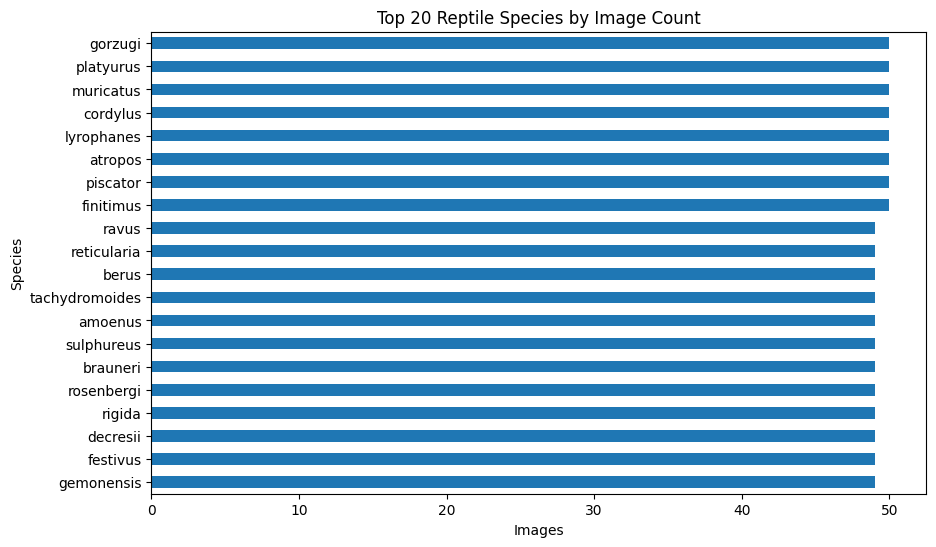

,count
count,528.000000
mean,35.511364
std,8.416115
min,20.000000
25%,28.000000
50%,37.000000
75%,42.000000
max,50.000000


In [13]:
from google.colab import output
output.no_vertical_scroll()

#@title 4e) Species Distribution
species_counts = df["species"].value_counts()

plt.figure(figsize=(10, 6))
species_counts.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Reptile Species by Image Count")
plt.xlabel("Images")
plt.ylabel("Species")
plt.show()

species_counts.describe()

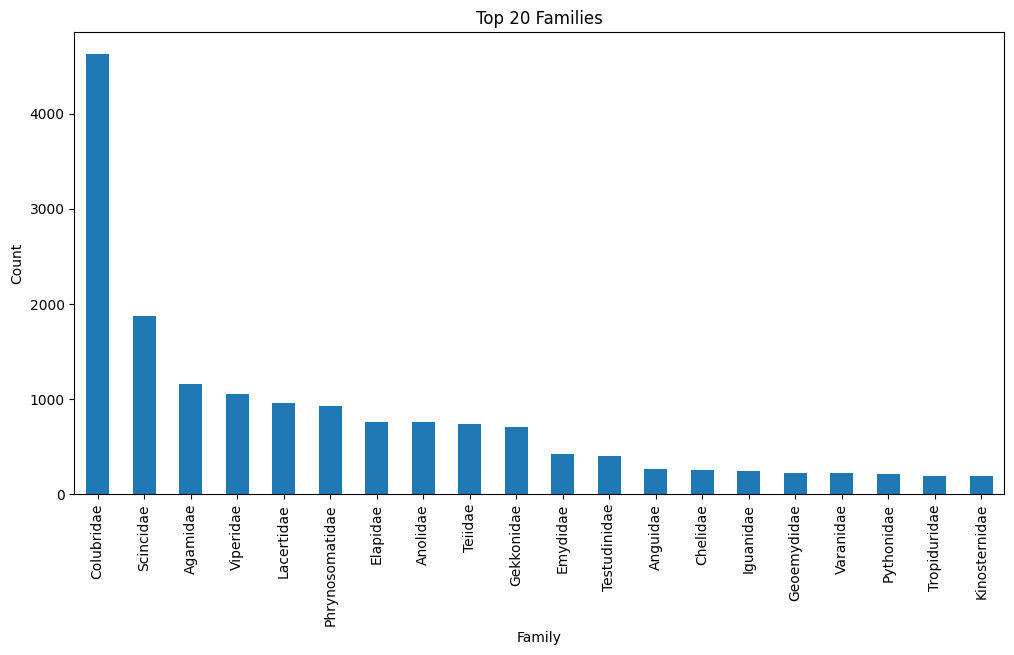

In [14]:
#@title 4f) Top 20 Families
plt.figure(figsize=(12,6))
df["family"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 Families")
plt.xlabel("Family")
plt.ylabel("Count")
plt.show()

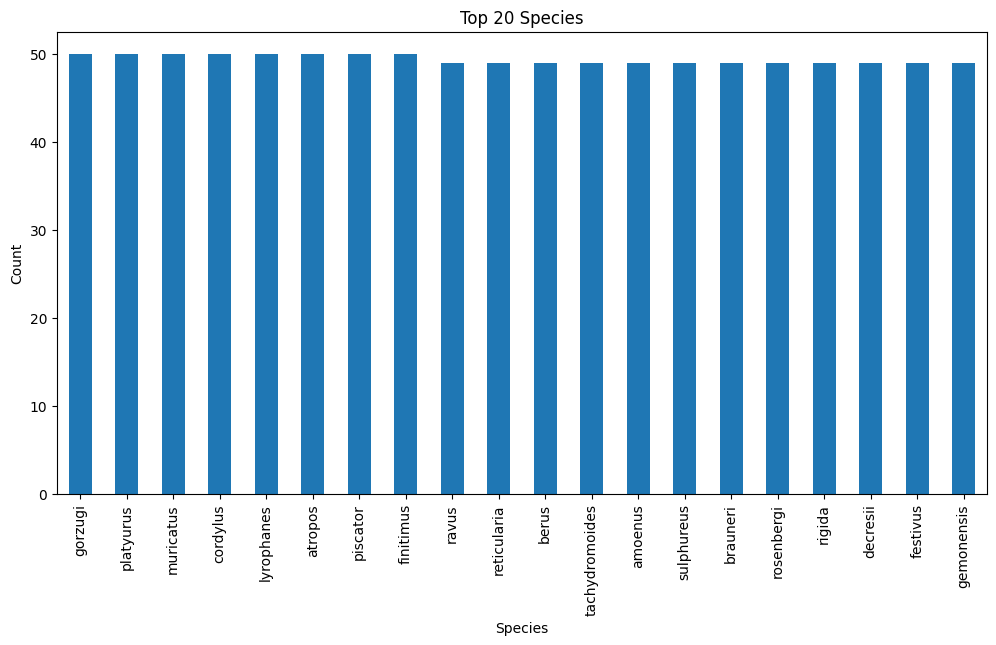

In [15]:
#@title 4g) Top 20 Species
plt.figure(figsize=(12,6))
df["species"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.show()

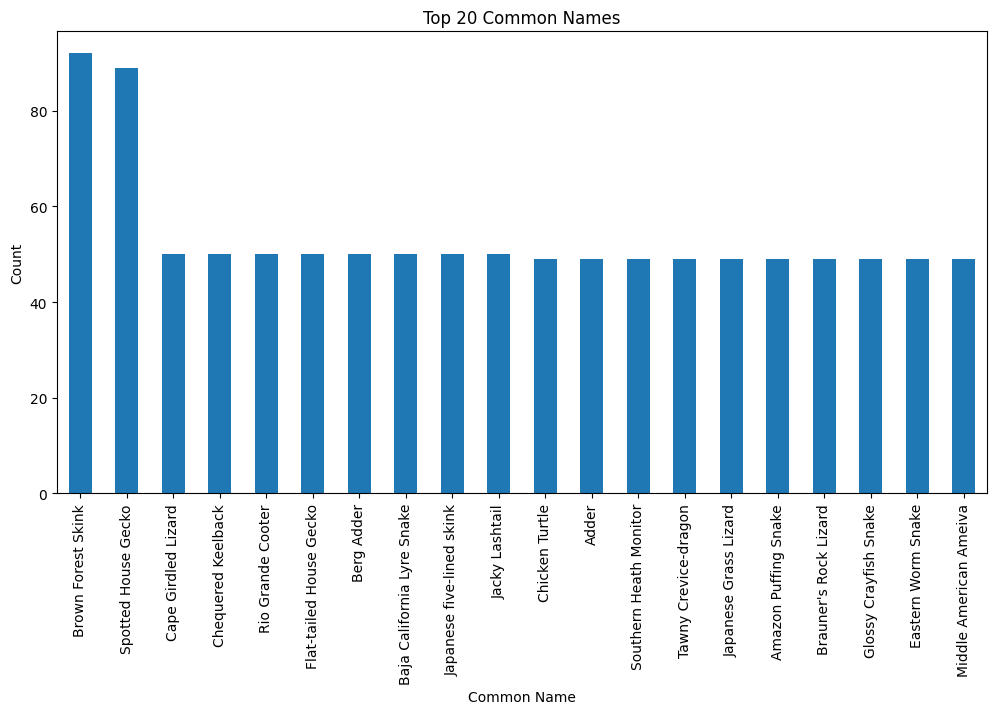

In [16]:
#@title 4h) Top 20 Common Names
plt.figure(figsize=(12,6))
df["common_name"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 Common Names")
plt.xlabel("Common Name")
plt.ylabel("Count")
plt.show()

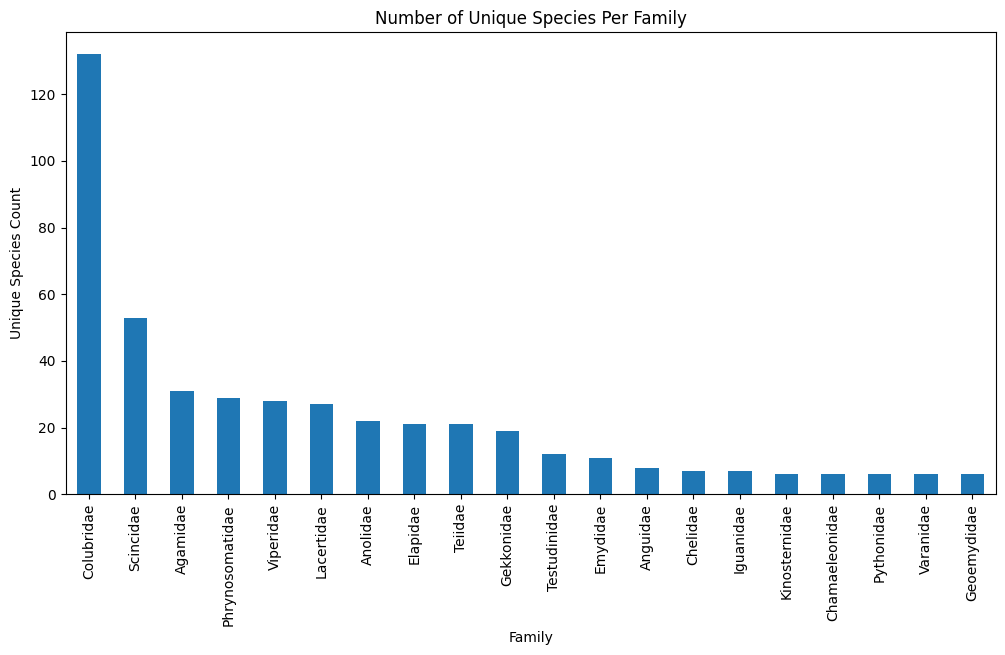

In [17]:
#@title 4i) Species per Family
family_species_counts = df.groupby("family")["species"].nunique().sort_values(ascending=False)

plt.figure(figsize=(12,6))
family_species_counts.head(20).plot(kind='bar')
plt.title("Number of Unique Species Per Family")
plt.xlabel("Family")
plt.ylabel("Unique Species Count")
plt.show()

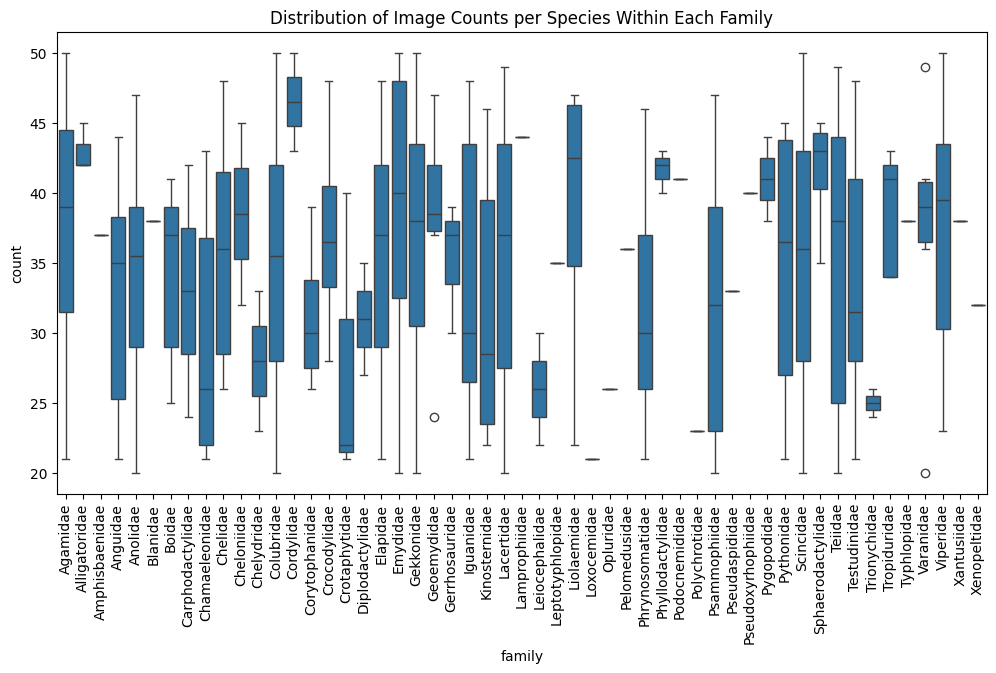

In [18]:
#@title 4j) Boxplot - Species
species_counts = df.groupby(["family", "species"]).size().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.boxplot(data=species_counts, x="family", y="count")
plt.xticks(rotation=90)
plt.title("Distribution of Image Counts per Species Within Each Family")
plt.show()

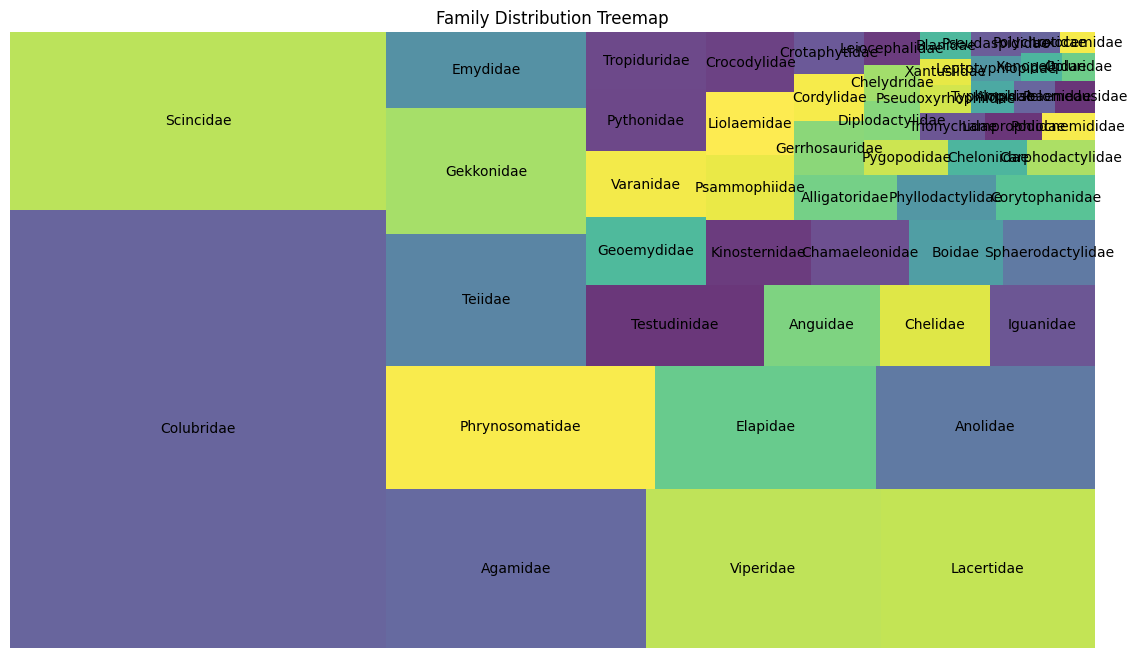

In [19]:
#@title 4k) Treemap - Family Distribution
family_counts = df["family"].value_counts()

plt.figure(figsize=(14,8))
squarify.plot(sizes=family_counts.values, label=family_counts.index, alpha=0.8)
plt.axis("off")
plt.title("Family Distribution Treemap")
plt.show()

In [21]:
#@title 4l) Sunburst

fig = px.sunburst(
    df,
    path=["family", "genus", "species"],
    values=None,
    title="Taxonomy Sunburst Chart (Family → Genus → Species)"
)
fig.update_layout(width=1000, height=1000)
fig.show()

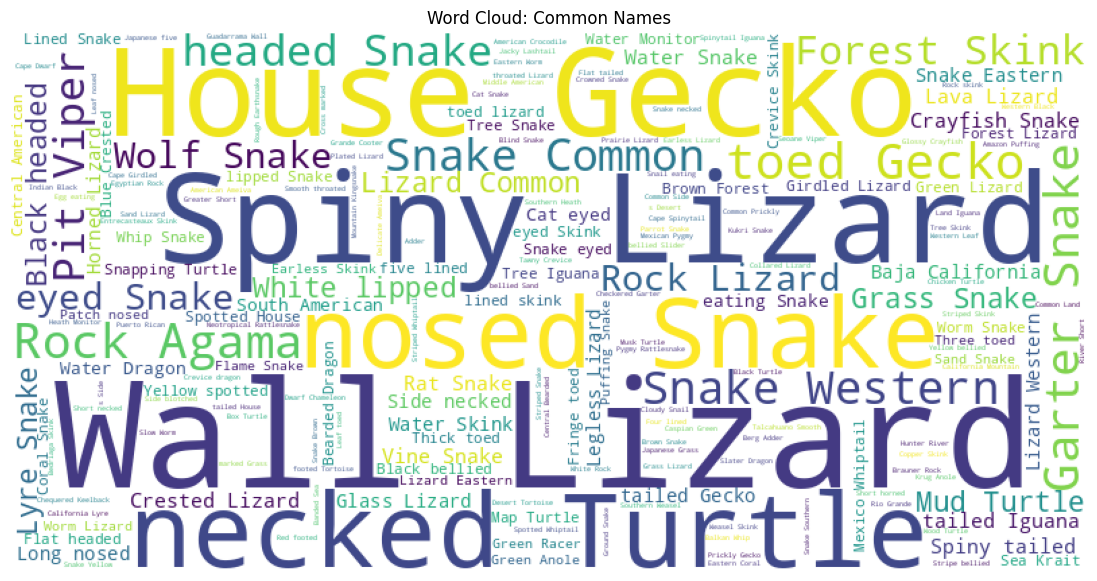

In [22]:
#@title 4m) Wordcloud - Common Names
text = " ".join(df["common_name"].dropna().astype(str).tolist())

wc = WordCloud(background_color="white", width=800, height=400).generate(text)
plt.figure(figsize=(14,7))
plt.imshow(wc)
plt.axis("off")
plt.title("Word Cloud: Common Names")
plt.show()

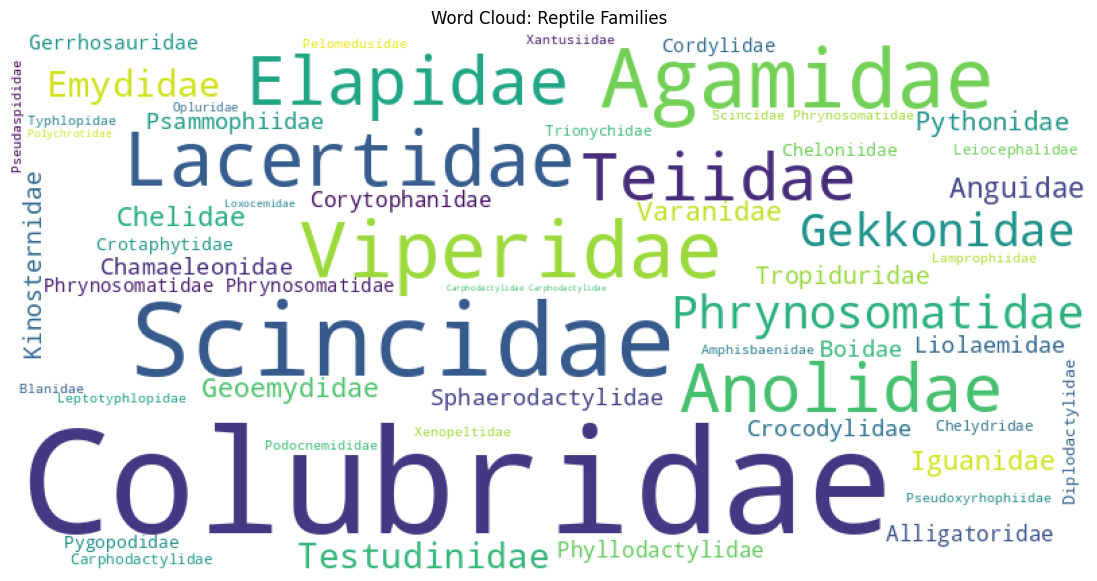

In [23]:
#@title 4n) Wordcloud - Family Names
text = " ".join(df["family"].dropna().astype(str).tolist())

wc = WordCloud(background_color="white", width=800, height=400).generate(text)
plt.figure(figsize=(14,7))
plt.imshow(wc)
plt.axis("off")
plt.title("Word Cloud: Reptile Families")
plt.show()

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4o) Visualize Sample Images From a Specific Species
species_list = df["species"].unique()
species_list[:20]

def show_species_samples(df, species, n=12):
    subset = df[df["species"] == species]
    sample_paths = subset["image_path_fixed"].sample(min(n, len(subset))).tolist()

    cols = 4
    rows = n // cols + 1

    plt.figure(figsize=(15, 12))
    for i, path in enumerate(sample_paths):
        try:
            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except:
            pass
    plt.suptitle(f"Samples of Species: {species}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example:
show_species_samples(df, species=species_list[0], n=12)

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4p) Show Samples from the MOST COMMON Species
top_species = df["species"].value_counts().idxmax()
print("Most common species:", top_species)

show_species_samples(df, species=top_species, n=12)

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4q) Show Samples from the RAREST Species
rare_species = df["species"].value_counts().idxmin()
print("Rarest species:", rare_species)

show_species_samples(df, species=rare_species, n=12)

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4r) Random Species Sample
import random
def sample_random_species(df):
    species = random.choice(df["species"].unique())
    print("Random species selected:", species)
    show_species_samples(df, species=species, n=12)

# Try multiple times:
sample_random_species(df)

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4s) Image Grid
def mosaic(df, n=25):
    sample_paths = df["image_path_fixed"].sample(n).tolist()
    plt.figure(figsize=(14, 14))

    for i, p in enumerate(sample_paths):
        try:
            img = Image.open(p)
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.axis("off")
        except:
            pass

    plt.suptitle("Random Mosaic of Reptilia Images", fontsize=16)
    plt.tight_layout()
    plt.show()

mosaic(df, n=25)

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4t) Check for Outliers - Small

df_small = df.sort_values(by=["width", "height"]).head(10)
df_small

show_random_images(df_small, n=min(10, len(df_small)))

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4u) Check for Outliers - Wide
df["aspect_ratio"] = df["width"] / df["height"]

df_wide = df.sort_values(by="aspect_ratio", ascending=False).head(10)

print("Wide images:")
display(df_wide)

show_random_images(df_wide, n=min(10, len(df_wide)))


In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4v) Check for Outliers - Tall
df["aspect_ratio"] = df["width"] / df["height"]

df_tall = df.sort_values(by="aspect_ratio", ascending=True).head(10)

print("Tall images:")
display(df_tall)

show_random_images(df_tall, n=min(10, len(df_tall)))

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title 4w) Check for Duplicates

# Define function to calculate perceptual hash (phash)
def calculate_phash(image_path):
    if pd.isna(image_path):
        return None
    try:
        img = Image.open(image_path)
        # Convert to RGB to avoid issues with different modes (e.g., RGBA, P)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return str(imagehash.phash(img))
    except (FileNotFoundError, UnidentifiedImageError, Exception) as e:
        return None

# Calculate phash for all images
# Only calculate if 'phash' column does not exist to avoid re-computation
if 'phash' not in df.columns:
    print("Calculating perceptual hashes (phash)... This might take a moment.")
    tqdm.pandas(desc="Calculating phash") # Enable progress bar for pandas apply
    df["phash"] = df["image_path_fixed"].progress_apply(calculate_phash)
    print("Perceptual hashes added to DataFrame.")

# Find duplicate groups based on phash
phash_counts = df["phash"].value_counts()
duplicate_hashes = phash_counts[phash_counts > 1].index

dup_groups = df[df["phash"].isin(duplicate_hashes)].sort_values(by="phash")

if not dup_groups.empty:
    print(f"Found {len(duplicate_hashes)} groups of duplicate images.")
    dup_sample = dup_groups.groupby("phash").head(2)  # two per duplicate group
    show_random_images(dup_sample, n=min(12, len(dup_sample)))
else:
    print("No duplicate images found based on perceptual hashing.")


## Models

In [ ]:
#@title Environment Setup
!pip -q install timm

import os
import math
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import timm
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [ ]:
#@title Mount Drive & Load Metadata
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

metadata_path = (
    "/content/drive/MyDrive/herpeton/biotrove_reptilia_curated/"
    "metadata/reptilia_curated_metadata.csv"
)

df = pd.read_csv(metadata_path)
print("Metadata shape:", df.shape)
df.head()

In [ ]:
#@title Encode Labels & Train/Val Split
# Use 'species' as label
assert "species" in df.columns, "Expected 'species' column in metadata."
assert "saved_file" in df.columns, "Expected 'saved_file' column with image paths."

# Encode species as integer labels
df["label_id"], label_names = pd.factorize(df["species"])
num_classes = len(label_names)
print("Number of classes:", num_classes)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42,
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))


In [ ]:
#@title Dataset & Transforms
class ReptiliaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = row["saved_file"]
        label = int(row["label_id"])

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label


# Image size compatible with ResNet50
image_size = 224

train_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.02,
        ),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

val_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

train_dataset = ReptiliaDataset(train_df, transform=train_transform)
val_dataset = ReptiliaDataset(val_df, transform=val_transform)


In [ ]:
#@title Dataloaders
# Your requested batch size:
requested_batch_size = 4096

# This may be too large for Colab; you can lower manually if you get OOM.
BATCH_SIZE = requested_batch_size

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

len(train_loader), len(val_loader)


In [ ]:
#@title Training Utilities
def create_warmup_scheduler(optimizer, warmup_steps: int):
    """
    Linear warmup from 0 -> 1 over warmup_steps, then stays at 1.
    """
    def lr_lambda(step: int):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0

    return LambdaLR(optimizer, lr_lambda)


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[LambdaLR],
    epoch: int,
    total_steps_done: int,
    use_bf16: bool = True,
) -> int:
    model.train()
    running_loss = 0.0
    n_batches = 0

    # Check bf16 capability
    can_bf16 = use_bf16 and torch.cuda.is_available() and torch.cuda.is_bf16_supported()

    scaler = torch.cuda.amp.GradScaler(enabled=not can_bf16)

    for images, labels in tqdm(loader, desc=f"Train Epoch {epoch}"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if can_bf16:
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)
        else:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)

        # backward + step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item()
        n_batches += 1
        total_steps_done += 1

    avg_loss = running_loss / max(1, n_batches)
    print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f}")
    return total_steps_done


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    all_preds: List[int] = []
    all_labels: List[int] = []

    for images, labels in tqdm(loader, desc="Eval"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(all_labels, all_preds)
    return acc, 0.0  # placeholder for loss if needed


### Model 1  - ResNet50 Baseline

In [ ]:
# Hyperparameters for Model 1
EPOCHS = 40
LR = 0.0005
WEIGHT_DECAY = 0.0004
WARMUP_STEPS = 5000  # global steps

# Build ResNet50 (using timm for consistency)
model_resnet = timm.create_model(
    "resnet50",
    pretrained=True,
    num_classes=num_classes,
)
model_resnet.to(device)

optimizer_resnet = AdamW(
    model_resnet.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

# Steps per epoch = batches in train loader
steps_per_epoch = len(train_loader)
total_training_steps = EPOCHS * steps_per_epoch
print("Steps per epoch:", steps_per_epoch)
print("Total training steps:", total_training_steps)

scheduler_resnet = create_warmup_scheduler(
    optimizer_resnet,
    warmup_steps=WARMUP_STEPS,
)

history_resnet = {"epoch": [], "val_acc": []}

global_step = 0

for epoch in range(1, EPOCHS + 1):
    global_step = train_one_epoch(
        model_resnet,
        train_loader,
        optimizer_resnet,
        scheduler_resnet,
        epoch,
        total_steps_done=global_step,
        use_bf16=True,
    )

    val_acc, _ = evaluate(model_resnet, val_loader)
    history_resnet["epoch"].append(epoch)
    history_resnet["val_acc"].append(val_acc)

    print(f"Epoch {epoch} - Val Accuracy: {val_acc:.4f}")


### Model 2 - CNN

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model_cnn = SmallCNN(num_classes=num_classes).to(device)

optimizer_cnn = AdamW(
    model_cnn.parameters(),
    lr=LR,  # same LR as ResNet
    weight_decay=WEIGHT_DECAY,
)

scheduler_cnn = create_warmup_scheduler(
    optimizer_cnn,
    warmup_steps=WARMUP_STEPS,
)

history_cnn = {"epoch": [], "val_acc": []}

global_step_cnn = 0

for epoch in range(1, EPOCHS + 1):
    global_step_cnn = train_one_epoch(
        model_cnn,
        train_loader,
        optimizer_cnn,
        scheduler_cnn,
        epoch,
        total_steps_done=global_step_cnn,
        use_bf16=True,
    )

    val_acc, _ = evaluate(model_cnn, val_loader)
    history_cnn["epoch"].append(epoch)
    history_cnn["val_acc"].append(val_acc)

    print(f"[CNN] Epoch {epoch} - Val Accuracy: {val_acc:.4f}")


### Compare Results

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_resnet["epoch"], history_resnet["val_acc"], label="ResNet50")
plt.plot(history_cnn["epoch"], history_cnn["val_acc"], label="Small CNN")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison")
plt.legend()
plt.grid(True)
plt.show()
